# Carbon Intensity

<br>

### Imports

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

<br>

### Data Preparation

We'll start by loading in the attribute data

In [3]:
attributes_fp = 'https://osuked.github.io/Power-Station-Dictionary/object_attrs/0_dictionary_attributes.csv'

df_attrs = pd.read_csv(attributes_fp)

df_attrs.head()

,attribute,id,value,datapackage,id_type,year,dictionary_id
0,Fuel Type,MARK-1,BIOMASS,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,NaN,10000
1,Longitude,10000,-3.603516,https://raw.githubusercontent.com/OSUKED/Dicti...,osuked_id,NaN,10000
2,Latitude,10000,57.480403,https://raw.githubusercontent.com/OSUKED/Dicti...,osuked_id,NaN,10000
3,Annual Output (MWh),MARK-1,355704.933,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,2016.0,10000
4,Annual Output (MWh),MARK-1,387311.364,https://raw.githubusercontent.com/OSUKED/Dicti...,ngc_bmu_id,2017.0,10000


<br>

We'll then extract the CO2 emissions data

Text(0.5, 0, 'CO2 Emissions (Tonnes)')

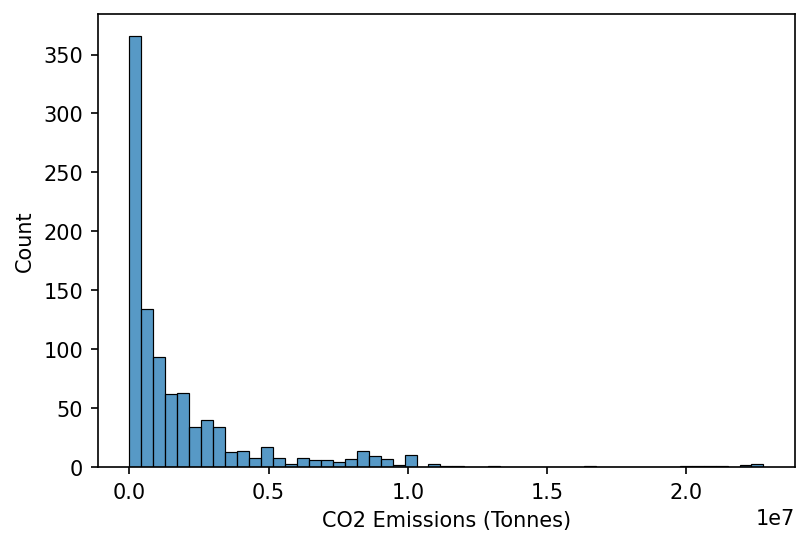

In [59]:
co2_attr = 'CO2 Emissions (Tonnes)'

s_site_co2 = (
    df_attrs
    .query('attribute==@co2_attr')
    [['dictionary_id', 'year', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'year': int, 'value': float})
    .groupby(['dictionary_id', 'year'])
    ['value']
    .sum()
)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_site_co2, ax=ax)

ax.set_xlabel(co2_attr)

<br>

As well as the power output data

Text(0.5, 0, 'Annual Output (MWh)')

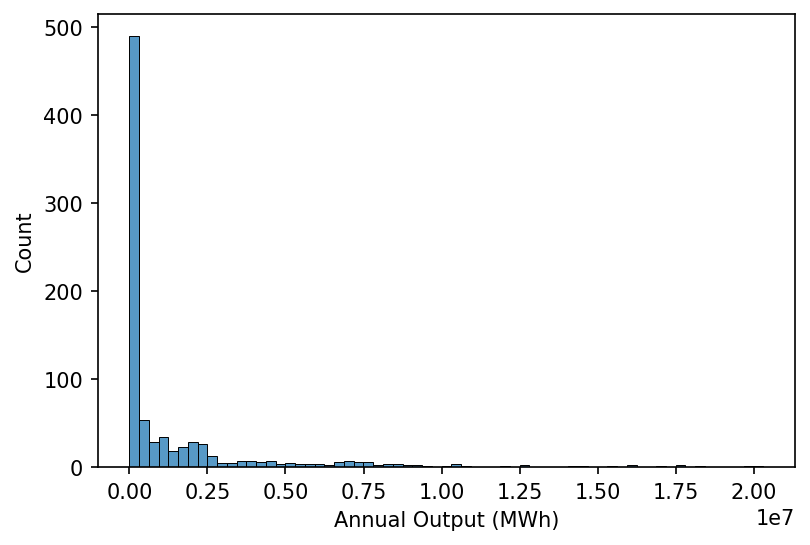

In [58]:
output_attr = 'Annual Output (MWh)'

s_site_output = (
    df_attrs
    .query('attribute==@output_attr')
    [['dictionary_id', 'year', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'year': int, 'value': float})
    .groupby(['dictionary_id', 'year'])
    ['value']
    .sum()
)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_site_output, ax=ax)

ax.set_xlabel(output_attr)

<br>

And lastly the fuel types of each plant

In [60]:
fuel_attr = 'Fuel Type'

s_site_fuel_type = (
    df_attrs
    .query('attribute==@fuel_attr')
    [['dictionary_id', 'value']]
    .dropna()
    .astype({'dictionary_id': int, 'value': str})
    .groupby('dictionary_id')
    ['value']
    .agg(lambda fuel_types: ', '.join(set(fuel_types)))
)

s_site_fuel_type.value_counts()

WIND                   113
CCGT                    34
NPSHYD                  13
NUCLEAR                  7
PS                       4
OCGT                     4
BIOMASS                  3
CCGT, OCGT               3
COAL, CCGT, OCGT         1
COAL, OCGT               1
OTHER                    1
Wind                     1
COAL, BIOMASS, OCGT      1
Name: value, dtype: int64

<br>

### Visualising Annual Carbon Intensities

We'll quickly check the data coverage

In [95]:
sites_with_co2_data = s_site_co2.index
sites_with_output_data = s_site_output.index

sites_with_both_datasets = sites_with_co2_data.intersection(sites_with_output_data)

sites_with_co2_data.size, sites_with_output_data.size, sites_with_both_datasets.size

(978, 830, 239)

<br>

And then visualise the annual carbon intensity estimates for OCGT and CCGT plants 

In [97]:
def hide_spines(ax, positions=["top", "right"]):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), "Position must be passed as a list "

    for position in positions:
        ax.spines[position].set_visible(False)

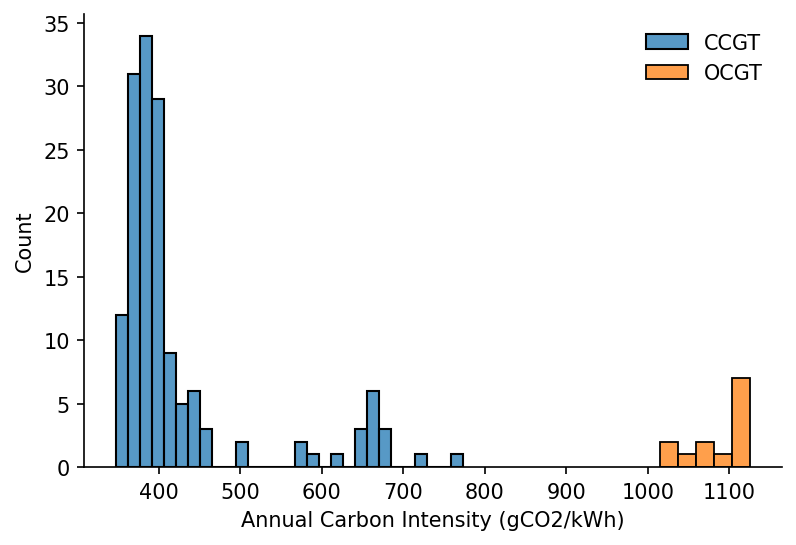

In [101]:
ccgt_sites = s_site_fuel_type.index[s_site_fuel_type=='CCGT'].intersection(s_site_co2.index.get_level_values(0)).intersection(s_site_output.index.get_level_values(0))
ocgt_sites = s_site_fuel_type.index[s_site_fuel_type=='OCGT'].intersection(s_site_co2.index.get_level_values(0)).intersection(s_site_output.index.get_level_values(0))

s_ccgt_carbon_intensities = 1000*(s_site_co2.loc[ccgt_sites]/s_site_output.loc[ccgt_sites]).dropna()
s_ccgt_carbon_intensities = s_ccgt_carbon_intensities.loc[(s_ccgt_carbon_intensities<1000)&(s_ccgt_carbon_intensities>200)]

s_ocgt_carbon_intensities = 1000*(s_site_co2.loc[ocgt_sites]/s_site_output.loc[ocgt_sites]).dropna()
s_ocgt_carbon_intensities = s_ocgt_carbon_intensities.loc[(s_ocgt_carbon_intensities<1200)&(s_ocgt_carbon_intensities>200)]

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.histplot(s_ccgt_carbon_intensities, ax=ax, label='CCGT')
sns.histplot(s_ocgt_carbon_intensities, ax=ax, color='C1', label='OCGT')

ax.set_xlabel('Annual Carbon Intensity (gCO2/kWh)')
hide_spines(ax)
ax.legend(frameon=False)